# Model Aggregations
This model anlayses the best models of the subsequent folders and aims at creating a stacked generalization of them.

In [1]:
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
sys.path.insert(0, "..")
import problem

## Load data

In [26]:
X_train, y_train = problem.get_train_data("..")
X_test, y_test = problem.get_test_data("..")
cv = problem.get_cv(X_train, y_train)

In [27]:
path_tuning = "./tree_models/results_tuning"

## Pipe setup

In [5]:
# date variables specifications
date_encoder = FunctionTransformer(
    problem._encode_dates, kw_args={"drop_date": False}
)
date_cols = ["year", "month", "weekday", "hour"]

# additional data variables specifications
add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

# numerical variables in X
num_cols = ["temp", "prcp", "wspd", "latitude", "longitude"]

# categorical variables in X
categorical_cols = ["counter_name", "wdir"]

# binary variables in X
bin_cols = ["public_holiday", "school_holiday", "covid_lockdown"]

# create column transformer with all one hot encoders
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("binary", "passthrough", bin_cols),
    ],
)


## Best models 

### Cat boost

In [6]:
regressor = CatBoostRegressor(
    depth=11, iterations=1200, rsm=0.05, sampling_frequency="PerTree", subsample=0.6, verbose=0
)

In [7]:
pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)

In [8]:
scores = cross_val_score(
    pipe, X_train.copy(), y_train.copy(), cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.86234972 -0.7242625  -0.65169391 -0.5684358  -0.67708743 -0.68242789
 -0.83058191 -0.69840705]
RMSE (all folds): 0.712 ± 0.089


In [9]:
pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.41
Test set, RMSE=0.44


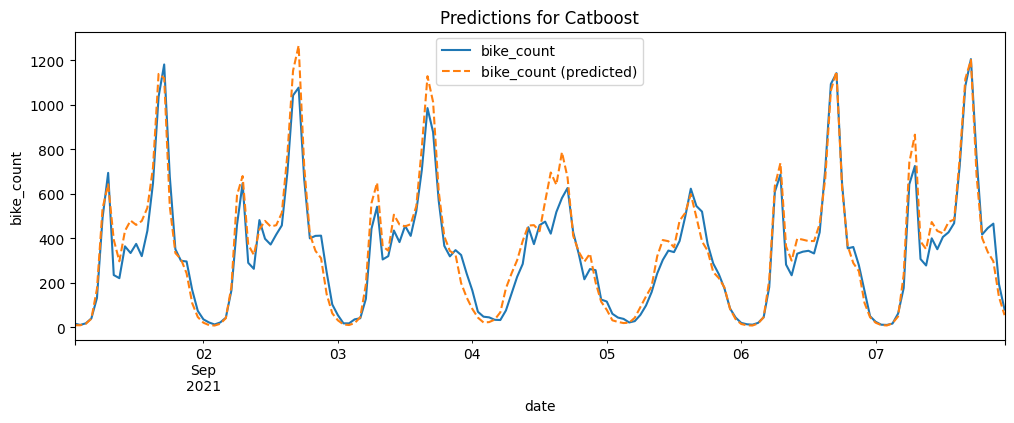

In [10]:
problem.week_plot(X_test, y_pred_test, y_test, "Catboost")

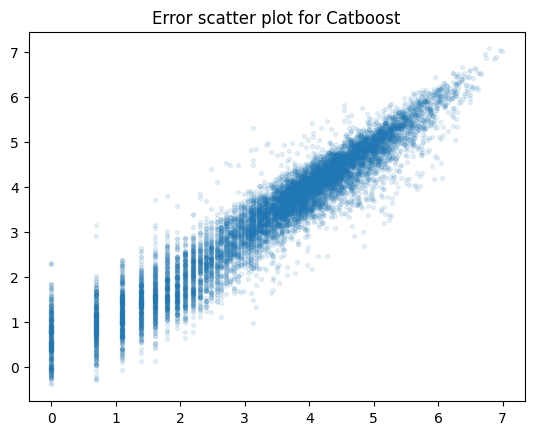

In [11]:
problem.error_plot(y_pred_test, y_test, "Catboost")

### XGB

In [28]:
xgb = XGBRegressor(
    colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=0.8,
)

In [29]:
xgb_pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    xgb,
)

In [30]:
scores = cross_val_score(
    xgb_pipe, X_train.copy(), y_train.copy(), cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.87626969 -0.74045674 -0.67290624 -0.5633227  -0.68536668 -0.69310274
 -0.90762571 -0.71484481]
RMSE (all folds): 0.732 ± 0.105


In [ ]:
scores = cross_val_score(
    xgb_pipe, X_train.copy(), y_train.copy(), cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.87626969 -0.74045674 -0.67290624 -0.5633227  -0.68536668 -0.69310274
 -0.90762571 -0.71484481]
RMSE (all folds): 0.732 ± 0.105


In [25]:
xgb_pipe.fit(X_train, y_train)

y_pred_train = xgb_pipe.predict(X_train)
y_pred_test = xgb_pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

KeyboardInterrupt: 

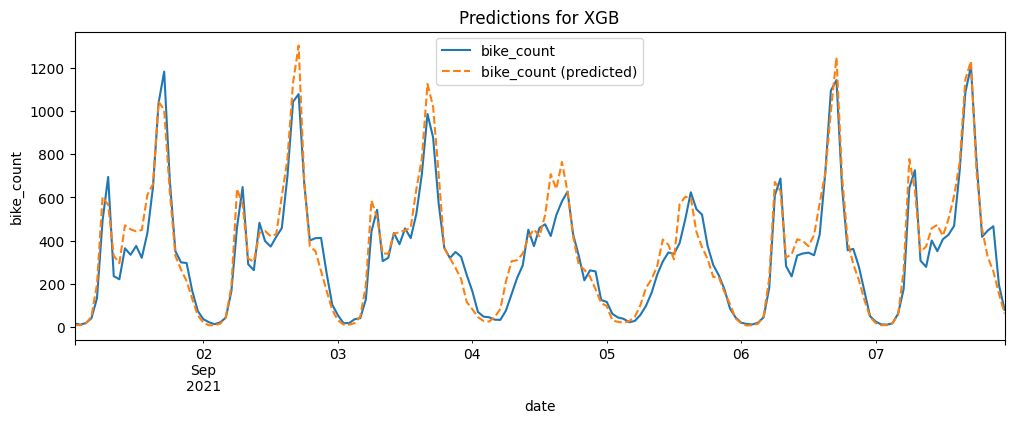

In [16]:
problem.week_plot(X_test, y_pred_test, y_test, "XGB")

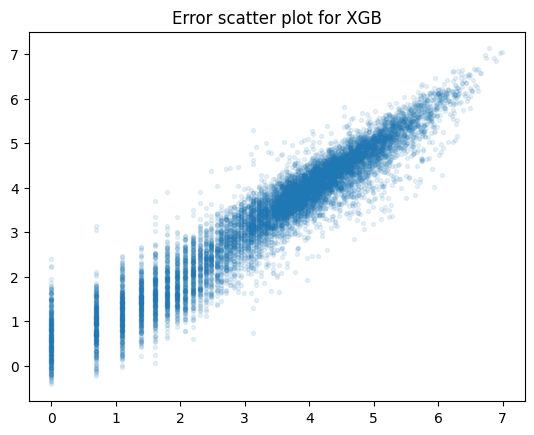

In [17]:
problem.error_plot(y_pred_test, y_test, "XGB")

### LightGBM

In [ ]:
pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
scores = cross_val_score(
    pipe, X_train.copy(), y_train.copy(), cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

In [ ]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

In [ ]:
problem.week_plot(X_test, y_pred_test, y_test, "LightGBM")

In [ ]:
problem.error_plot(y_pred_test, y_test, "LightGBM")